In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import time, copy, decimal
from pyswarm import pso # https://pythonhosted.org/pyswarm/
from IPython.display import clear_output

In [2]:
def simulated_annealing(objective, bounds, n_iterations, step_size, temp):
    # generate an initial point
    best = bounds[:, 0] + np.random.rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
    # evaluate the initial point
    best_eval = objective(best)
    # current working solution
    curr, curr_eval = best, best_eval
    scores = list()
    # run the algorithm
    for i in range(n_iterations):
        # take a step
        candidate = curr + np.random.randn(len(bounds)) * step_size
        # evaluate candidate point
        candidate_eval = objective(candidate)
        # check for new best solution
        if candidate_eval < best_eval:
            # store new best point
            best, best_eval = candidate, candidate_eval
            # keep track of scores
            scores.append(best_eval)
            # report progress
            #print('>%d f(%s) = %.5f' % (i, best, best_eval))
        # difference between candidate and current point evaluation
        diff = candidate_eval - curr_eval
        # calculate temperature for current epoch
        t = temp / float(i + 1)
        # calculate metropolis acceptance criterion
        metropolis = np.exp(-diff / t)
        # check if we should keep the new point
        if diff < 0 or np.random.rand() < metropolis:
            # store the new current point
            curr, curr_eval = candidate, candidate_eval
    return [best, best_eval, scores]

# Task 1

In [3]:
np.random.seed(1000)

f = lambda x: 1 / (x**2 - 3*x + 2)

k = np.array([ki for ki in range(0, 1001)])
x = 3 * k / 1000
y = f(x)
y[y < -100] = -100 + np.random.normal(size=y[y < -100].shape[0])
y[y > 100] = 100 + np.random.normal(size=y[y > 100].shape[0])

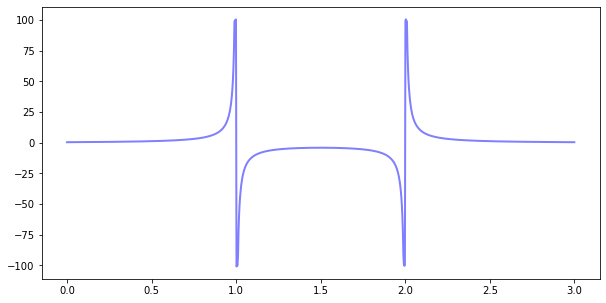

In [4]:
plt.figure(figsize=(10,5))
plt.plot(x, y, 'b', lw=2, alpha=0.5)

In [5]:
def approx(x, a, b, c, d):
    return (a*x + b) / (x**2 + c*x + d)

def least_squares(vector, func, x, y):
    return np.sum( (func(x, *vector) - y)**2 )

def least_squares_lm(vector, func, x, y):
    return func(x, *vector) - y

# optfun = lambda vector: least_squares(vector, approx, x, y)
# optfun_lm = lambda vector: least_squares_lm(vector, approx, x, y)

In [27]:
%%time

eps = 1e-3

x0 = np.ones((4, )) * 10

opt_nelder_mead = optimize.minimize(least_squares, x0, method='nelder-mead', args=(approx, x, y),
                                    options={'disp': True, 'maxiter': 1000, 'fatol': eps})
print("nelder-mead done")

x0 = np.ones((4, )) * 10
opt_lm = optimize.least_squares(least_squares_lm, x0, method='lm', args=(approx, x, y), ftol=1e-5)

print("lm done")

lb = np.ones((4, )) * -10
ub = np.ones((4, )) * 10
xopt, fopt = pso(least_squares, lb, ub, maxiter=95, args=(approx, x, y), swarmsize=1000, minfunc=eps)

print("pso done")

bounds = np.asarray([[-10, 10], [-10, 10], [-10, 10], [-10, 10]])
opt_diff_ev = optimize.differential_evolution(least_squares, bounds, args=(approx, x, y), tol=eps)

Optimization terminated successfully.
         Current function value: 135192.844039
         Iterations: 403
         Function evaluations: 693
nelder-mead done
lm done
Stopping search: Swarm best objective change less than 0.001
pso done
Wall time: 1.61 s


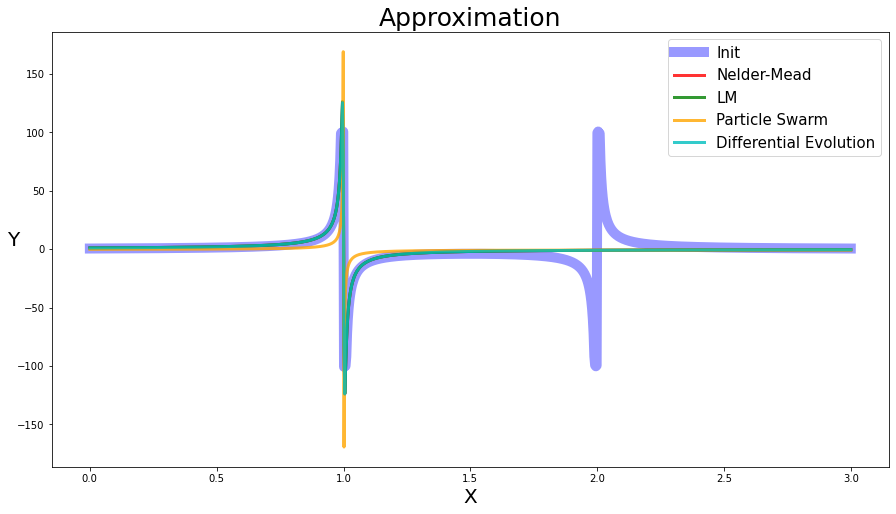

In [28]:
plt.figure(figsize=(15,8))
plt.title("Approximation", fontsize=25)
plt.xlabel("X", fontsize=20)
plt.ylabel("Y", fontsize=20, rotation=0)
plt.plot(x, y, 'b', lw=10, alpha=0.4, label="Init")
plt.plot(x, approx(x, *opt_nelder_mead.x), 'r', label="Nelder-Mead", lw=3, alpha=0.8)
plt.plot(x, approx(x, *opt_lm.x), 'g', label="LM", lw=3, alpha=0.8)
plt.plot(x, approx(x, *xopt), color='orange', label="Particle Swarm", lw=3, alpha=0.8)
plt.plot(x, approx(x, *opt_diff_ev.x), color='c', label="Differential Evolution", lw=3, alpha=0.8)
plt.legend(fontsize=15)

# Task 2

In [8]:
coordinates = np.asarray([
  [0.549963e-07,  0.985808e-08],
  [-28.8733,     -0.797739e-07],
  [-79.2916,      -21.4033],    
  [-14.6577,      -43.3896],    
  [-64.7473,       21.8982],    
  [-29.0585,      -43.2167],    
  [-72.0785,      0.181581],    
  [-36.0366,      -21.6135],    
  [-50.4808,       7.37447],    
  [-50.5859,      -21.5882],    
 [-0.135819,      -28.7293],    
  [-65.0866,      -36.0625],    
  [-21.4983,       7.31942],    
  [-57.5687,      -43.2506],    
  [-43.0700,       14.5548]])

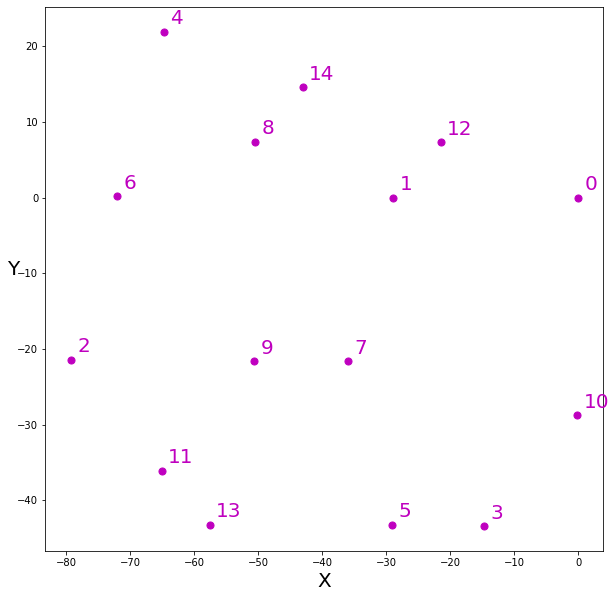

In [63]:
def plot_map(coordinates):
    fig, ax = plt.figure(figsize=(10,10))
    plt.xlabel("X", fontsize=20)
    plt.ylabel("Y", fontsize=20, rotation=0)
    plt.scatter(coordinates[:, 0], coordinates[:, 1], s=50, c='m', marker='o')
    for i, point in enumerate(coordinates):
        plt.text(point[0]+1, point[1]+1, s=(i), size=20, color='m')
    return fig
f = plot_map(coordinates)

In [56]:
def get_distance(p1, p2):
    return np.sqrt( np.sum( (p2 - p1)**2 ) )

def get_distmatrix(coordinates, r=0):
    distmatrix = np.ones((coordinates.shape[0], coordinates.shape[0]))

    for i, point1 in enumerate(coordinates):
        for j, point2 in enumerate(coordinates):
            distmatrix[i, j] = np.round(get_distance(point1, point2), r)
    return distmatrix

In [250]:
def get_track(sequence,  coordinates, plot=False):
    if plot:
        fig = plot_map(coordinates)
        
    distmatrix = get_distmatrix(coordinates, r=0)
    track = 0
    p_i = 0
    for i in range(len(sequence) + 1):
        try:
            p_j = sequence[i]
        except:
            p_j = 0
        track += distmatrix[p_i, p_j]
            
        if plot:
            plt.arrow(coordinates[p_i, 0], coordinates[p_i, 1], 
                         coordinates[p_j, 0] - coordinates[p_i, 0], coordinates[p_j, 1] - coordinates[p_i, 1], 
                     color='r', lw=0.002, width = 0.5, length_includes_head = True, alpha=0.6)
        try:
            p_i = sequence[i]
        except:
            break
            
    if plot:
        plt.title(f"Track = {track}", fontsize=25)
        plt.show()
        #time.sleep(0.5)
        plt.close(fig)
        #clear_output()
    return track

In [251]:
np.arange(0, 15)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

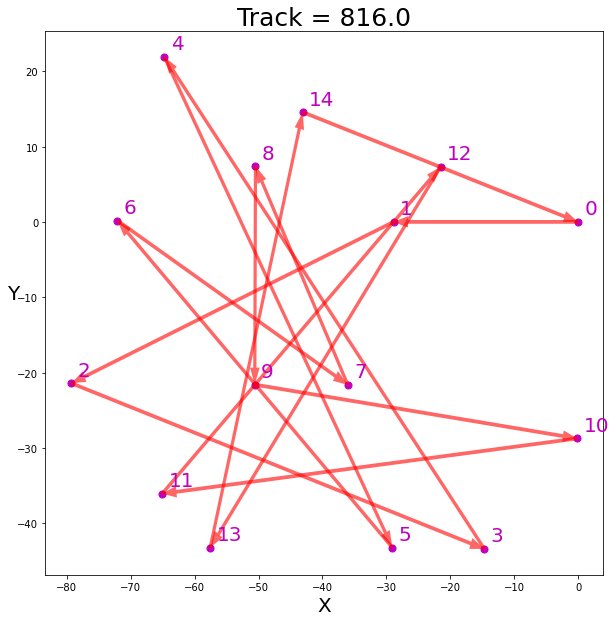

816.0

In [315]:
get_track(np.arange(1, 15), coordinates, plot=True)

In [320]:
# optimization
sequence = np.arange(1, 15)

T = 100000
Alpha = 0.999
X = np.random.permutation(sequence)

scores = []
i = 0
Z = 1000
while Z > 370:
    i += 1
    Z = get_track(X, coordinates)
    print("Iter: ", i)
    scores.append(Z)
    Xp = copy.deepcopy(X)
    a = random.sample(range(0, 14), 2)
    Xp[a[0]], Xp[a[1]] = Xp[a[1]], Xp[a[0]]
    Zp = get_track(Xp, coordinates, plot=False)
    
    #decimal.getcontext().prec = 5
    deltaZ = Zp - Z
    Prob = np.exp(-deltaZ / T)
    #np.exp(-deltaZ / T)
    #decimal.Decimal(-deltaZ/T).exp()
    print("probabilidad: ", Prob)
    print("Temperatura: ",T)
    print("Z: ",Z)
    print("Zp: ",Zp)
    print("\n")    
    if Zp < Z:
        X = Xp
        T = T*Alpha
    else:
        num = random.randint(0,1)
        if num < Prob:
            X = Xp
            T = T*Alpha
        

Iter:  1
probabilidad:  1.00033005445599
Temperatura:  100000
Z:  600.0
Zp:  567.0


Iter:  2
probabilidad:  0.9998898959517856
Temperatura:  99900.0
Z:  567.0
Zp:  578.0


Iter:  3
probabilidad:  0.999158671592013
Temperatura:  99800.1
Z:  578.0
Zp:  662.0


Iter:  4
probabilidad:  1.0004113170317679
Temperatura:  99700.29990000001
Z:  662.0
Zp:  621.0


Iter:  5
probabilidad:  1.0
Temperatura:  99600.59960010002
Z:  621.0
Zp:  621.0


Iter:  6
probabilidad:  0.9992874069009177
Temperatura:  99600.59960010002
Z:  621.0
Zp:  692.0


Iter:  7
probabilidad:  1.0001706962703567
Temperatura:  99600.59960010002
Z:  621.0
Zp:  604.0


Iter:  8
probabilidad:  1.0004925786442207
Temperatura:  99500.99900049991
Z:  604.0
Zp:  555.0


Iter:  9
probabilidad:  0.9994870608596597
Temperatura:  99401.4980014994
Z:  555.0
Zp:  606.0


Iter:  10
probabilidad:  0.9998288198786734
Temperatura:  99302.0965034979
Z:  606.0
Zp:  623.0


Iter:  11
probabilidad:  0.999566638396535
Temperatura:  99202.7944069

<ipython-input-320-a39c47bc1f29>:23: RuntimeWarning: overflow encountered in exp
  Prob = np.exp(-deltaZ / T)


 19433
probabilidad:  3.056386039263097e-80
Temperatura:  0.1529306084959648
Z:  473.0
Zp:  501.0


Iter:  19434
probabilidad:  1.2219917709030612e-108
Temperatura:  0.1529306084959648
Z:  473.0
Zp:  511.0


Iter:  19435
probabilidad:  1.1293654845776093e-196
Temperatura:  0.1529306084959648
Z:  473.0
Zp:  542.0


Iter:  19436
probabilidad:  1.2351464838166329e-179
Temperatura:  0.1529306084959648
Z:  473.0
Zp:  536.0


Iter:  19437
probabilidad:  1.5200372790364838e-148
Temperatura:  0.15277767788746882
Z:  536.0
Zp:  588.0


Iter:  19438
probabilidad:  696.0759827930285
Temperatura:  0.15277767788746882
Z:  536.0
Zp:  535.0


Iter:  19439
probabilidad:  2.9073247524102564e-09
Temperatura:  0.15262490020958136
Z:  535.0
Zp:  538.0


Iter:  19440
probabilidad:  4.486209200688417e-160
Temperatura:  0.15262490020958136
Z:  535.0
Zp:  591.0


Iter:  19441
probabilidad:  8.452537215977359e-18
Temperatura:  0.15262490020958136
Z:  535.0
Zp:  541.0


Iter:  19442
probabilidad:  3.54392843264

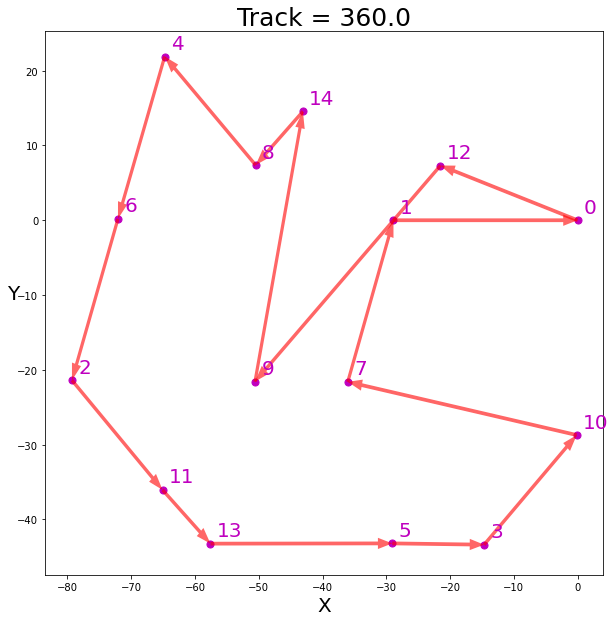

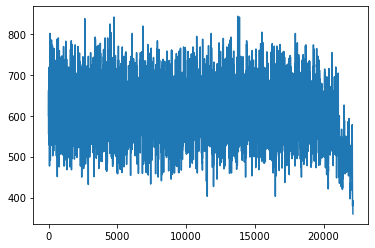

In [321]:
get_track(X, coordinates, plot=True)
plt.plot(scores)

In [312]:
# optimization
sequence = np.arange(1, 15)

T = 100000
Alpha = 0.999
X = np.random.permutation(sequence)

scores = []
i = 0
Z = 1000
while Z > 290:
    i += 1
    Z = get_track(X, coordinates)
    scores.append(Z)
    Xp = copy.deepcopy(X)
    a = random.sample(range(0, 14), 2)
    Xp[a[0]], Xp[a[1]] = Xp[a[1]], Xp[a[0]]
    Zp = get_track(Xp, coordinates, plot=False)
    
    #decimal.getcontext().prec = 5
    deltaZ = Zp - Z
    Prob = np.exp(-deltaZ / T)
    #np.exp(-deltaZ / T)
    #decimal.Decimal(-deltaZ/T).exp()
    print("probabilidad: ", Prob)
    print("Temperatura: ",T)
    print("Z: ",Z)
    print("Zp: ",Zp)
    print("\n")    
    if Zp < Z:
        X = Xp
        T = T*Alpha
    else:
        num = random.randint(0,1)
        if num < Prob:
            X = Xp
            T = T*Alpha

probabilidad:  0.999820016199028
Temperatura:  100000
Z:  650.0
Zp:  668.0


probabilidad:  0.9993602047563164
Temperatura:  100000
Z:  650.0
Zp:  714.0


probabilidad:  0.9996800511945391
Temperatura:  100000
Z:  650.0
Zp:  682.0


probabilidad:  0.9999499512024328
Temperatura:  99900.0
Z:  682.0
Zp:  687.0


probabilidad:  0.9998396923700007
Temperatura:  99800.1
Z:  687.0
Zp:  703.0


probabilidad:  0.9998597294182774
Temperatura:  99800.1
Z:  687.0
Zp:  701.0


probabilidad:  0.9999598805644054
Temperatura:  99700.29990000001
Z:  701.0
Zp:  705.0


probabilidad:  1.0001303992825494
Temperatura:  99700.29990000001
Z:  701.0
Zp:  688.0


probabilidad:  1.0002610766797948
Temperatura:  99600.59960010002
Z:  688.0
Zp:  662.0


probabilidad:  1.000110557764917
Temperatura:  99500.99900049991
Z:  662.0
Zp:  651.0


probabilidad:  0.9999094622037423
Temperatura:  99401.4980014994
Z:  651.0
Zp:  660.0


probabilidad:  1.0001911622698425
Temperatura:  99401.4980014994
Z:  651.0
Zp:  632.0



<ipython-input-312-8e6958e84281>:22: RuntimeWarning: overflow encountered in exp
  Prob = np.exp(-deltaZ / T)


 126770.54481956347
Temperatura:  0.17021082486415212
Z:  625.0
Zp:  623.0


probabilidad:  1.2416974145102163e-161
Temperatura:  0.17004061403928797
Z:  623.0
Zp:  686.0


probabilidad:  1.5145757445261055e+166
Temperatura:  0.16987057342524867
Z:  686.0
Zp:  621.0


probabilidad:  2.9173982369417123e+171
Temperatura:  0.16970070285182343
Z:  621.0
Zp:  554.0


probabilidad:  5.354783012826112e+71
Temperatura:  0.1695310021489716
Z:  554.0
Zp:  526.0


probabilidad:  1.6313315041376556e-231
Temperatura:  0.16936147114682262
Z:  526.0
Zp:  616.0


probabilidad:  3.84846994315267e-57
Temperatura:  0.16936147114682262
Z:  526.0
Zp:  548.0


probabilidad:  3.636747989279239e-75
Temperatura:  0.1691921096756758
Z:  548.0
Zp:  577.0


probabilidad:  1.136113157988639e+113
Temperatura:  0.16902291756600013
Z:  577.0
Zp:  533.0


probabilidad:  9.01503018551668e-199
Temperatura:  0.16885389464843412
Z:  533.0
Zp:  610.0


probabilidad:  8.930448965751315e-217
Temperatura:  0.16885389464843412

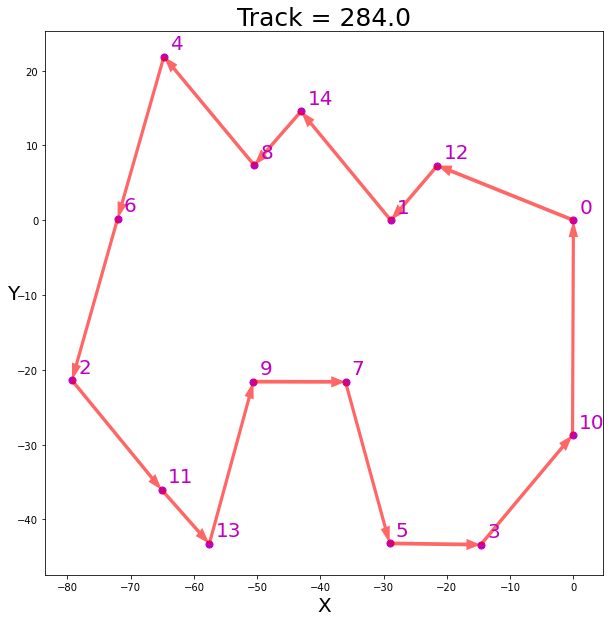

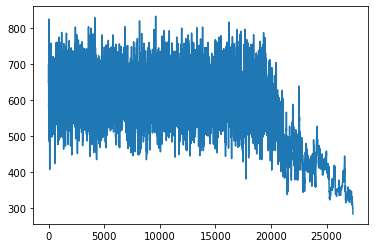

In [313]:
get_track(X, coordinates, plot=True)
plt.plot(scores)

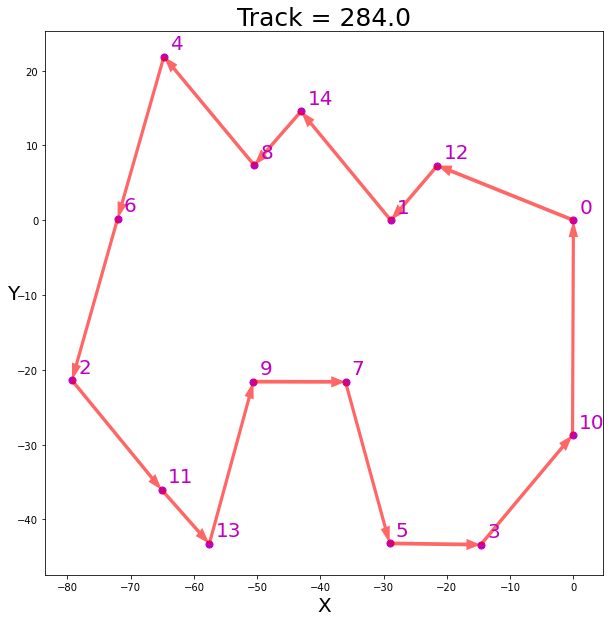

284.0

In [283]:
answer = np.asarray([13, 2,15, 9, 5, 7, 3,12,14,10, 8, 6, 4,11,]) - 1
get_track(answer, coordinates, plot=True)